## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.transforms as transforms

import torchvision.models as models

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
device

device(type='cuda')

## Hyperparameter Setting

In [4]:
CFG = {
    'IMG_SIZE':224, # fixed
    'EPOCHS':10,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':32,
    'SEED':40
}

## Fixed RandomSeed

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing
#### 1. Load Dataframe
#### 2. 결측치 보완
#### 3. Train / Validation Split
#### 4. Numeric Feature Scaling / Categorical Featrue Label-Encoding

In [6]:
train_df = pd.read_csv('C:/Users/sanda/Desktop/dacon/train.csv')
test_df = pd.read_csv('C:/Users/sanda/Desktop/dacon/test.csv')

In [7]:
train_df.head()

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,./train_imgs/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,NaN,NaN,NaN,0
1,BC_01_0002,./train_imgs/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,...,NaN,0.0,NaN,70.0,0.0,0.0,NaN,NaN,NaN,1
2,BC_01_0003,./train_imgs/BC_01_0003.png,-,37,2015-10-29,1,2,1,NaN,2.0,...,7.0,1.0,4.0,7.0,0.0,1.0,NaN,NaN,0.0,0
3,BC_01_0004,./train_imgs/BC_01_0004.png,-,54,2016-03-08,1,2,1,0.0,3.0,...,NaN,0.0,NaN,1.0,1.0,3.0,NaN,NaN,NaN,0
4,BC_01_0005,./train_imgs/BC_01_0005.png,-,57,2015-10-30,1,2,1,8.0,2.0,...,8.0,0.0,NaN,8.0,1.0,2.0,1.0,5.44,NaN,0


In [8]:
test_df.head()

,ID,img_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,HG,...,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation
0,BC_01_0011,./test_imgs/BC_01_0011.png,55,2015-11-17,2,2,1,23.0,2.0,2.0,...,1.0,8.0,0.0,2.0,5.00,0.0,1.0,NaN,NaN,NaN
1,BC_01_0220,./test_imgs/BC_01_0220.png,43,2020-06-09,4,2,1,13.0,3.0,2.0,...,1.0,4.0,1.0,8.0,8.67,0.0,0.0,NaN,NaN,NaN
2,BC_01_0233,./test_imgs/BC_01_0233.png,76,2020-05-14,1,1,1,NaN,NaN,NaN,...,1.0,6.0,1.0,6.0,NaN,NaN,2.0,NaN,NaN,NaN
3,BC_01_0258,./test_imgs/BC_01_0258.png,58,2020-05-20,1,2,1,1.3,2.0,2.0,...,1.0,7.0,0.0,NaN,21.17,1.0,3.0,NaN,NaN,0.0
4,BC_01_0260,./test_imgs/BC_01_0260.png,56,2020-05-20,1,2,2,15.0,3.0,3.0,...,1.0,8.0,1.0,3.0,20.57,1.0,3.0,NaN,NaN,NaN


In [9]:
train_df['암의 장경'] = train_df['암의 장경'].fillna(train_df['암의 장경'].mean())
train_df = train_df.fillna(0)

test_df['암의 장경'] = test_df['암의 장경'].fillna(train_df['암의 장경'].mean())
test_df = test_df.fillna(0)

In [10]:
# train_df, val_df, train_labels, val_labels = train_test_split(
#                                                     train_df.drop(columns=['N_category']), 
#                                                     train_df['N_category'], 
#                                                     test_size=0.2, 
#                                                     random_state=CFG['SEED']
#                                                 )

In [11]:
train_df, val_df, train_labels, val_labels = train_test_split(
                                                    train_df.drop(columns=['N_category']), 
                                                    train_df['N_category'], 
                                                    test_size=0.2, 
                                                    random_state=CFG['SEED'],
                                                    stratify=train_df['N_category']
                                                    
                                                )

In [12]:
def get_values(value):
    return value.values.reshape(-1, 1)

numeric_cols = ['나이', '암의 장경', 'ER_Allred_score', 'PR_Allred_score', 'KI-67_LI_percent', 'HER2_SISH_ratio']
ignore_cols = ['ID', 'img_path', 'mask_path', '수술연월일', 'N_category']

for col in train_df.columns:
    if col in ignore_cols:
        continue
    if col in numeric_cols:
        scaler = StandardScaler()
        train_df[col] = scaler.fit_transform(get_values(train_df[col]))
        val_df[col] = scaler.transform(get_values(val_df[col]))
        test_df[col] = scaler.transform(get_values(test_df[col]))
    else:
        le = LabelEncoder()
        train_df[col] = le.fit_transform(get_values(train_df[col]))
        val_df[col] = le.transform(get_values(val_df[col]))
        test_df[col] = le.transform(get_values(test_df[col]))

## CustomDataset

In [13]:
class CustomDataset(Dataset):
    def __init__(self, medical_df, labels, transforms=None):
        self.medical_df = medical_df
        self.transforms = transforms
        self.labels = labels
        
    def __getitem__(self, index):
        img_path = self.medical_df['img_path'].iloc[index]
        img_folder = img_path.split('/')[-2]
        img_folder = img_folder + '_HnE_vector'
        img_name = img_path.split('/')[-1]
        img_name = img_name.replace('png' , 'npy')
        
        img_path = 'C:/Users/sanda/Desktop/dacon/' + img_folder + '/' + img_name
        image = np.load(img_path) # fixed
        #image = cv2.imread(img_path)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
                
        if self.labels is not None:
            tabular = torch.Tensor(self.medical_df.drop(columns=['ID', 'img_path', 'mask_path', '수술연월일']).iloc[index])
            label = self.labels[index]
            return image, tabular, label
        else:
            tabular = torch.Tensor(self.medical_df.drop(columns=['ID', 'img_path', '수술연월일']).iloc[index])
            return image, tabular
        
    def __len__(self):
        return len(self.medical_df)

In [14]:
# # fixed

# train_transforms = A.Compose([
#                             A.HorizontalFlip(),
#                             A.VerticalFlip(),
#                             A.Rotate(limit=90, border_mode=cv2.BORDER_CONSTANT,p=0.3),
#                             A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
#                             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
#                             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True, p=1.0),
#                             ToTensorV2()
#                             ])

# test_transforms = A.Compose([
#                             A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
#                             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
#                             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True, p=1.0),
#                             ToTensorV2()
#                             ])

In [15]:
T = transforms.Compose([
                        
                        #transforms.Grayscale(num_output_channels=1),
                        transforms.RandomRotation(degrees=90),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        #transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0),
                        #transforms.Resize(image_resize), # (h, w) 순서
                        transforms.ToTensor(),
                        transforms.Normalize((0.5), (0.5))
                   
                       ])

valid_T = transforms.Compose([
                        
                        #transforms.Grayscale(num_output_channels=1),
                        #transforms.Resize(image_resize), # (h, w) 순서
                        transforms.ToTensor(),
                        transforms.Normalize((0.5), (0.5))

                       ])

In [16]:
from torchvision.datasets import ImageFolder

img_path = 'C:\\Users\\sanda\\Desktop\\dacon\\traing_imgs_HnE_MIL224'

#train_dataset = CustomDataset(train_df, train_labels.values, train_transforms)
train_dataset = ImageFolder(root=os.path.join(img_path,'train'), transform=T)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)


#val_dataset = CustomDataset(val_df, val_labels.values, test_transforms)
val_dataset = ImageFolder(root=os.path.join(img_path,'val'),transform =valid_T)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)


## Model Architecture

In [17]:
# class ImgFeatureExtractor(nn.Module):
#     def __init__(self):
#         super(ImgFeatureExtractor, self).__init__()
#         #self.backbone = models.efficientnet_b0(pretrained=True) # fixed
#         self.backbone = models.convnext_tiny(pretrained=False)
#         #self.backbone = models.convnext_base(pretrained=False)
#         self.first_conv = nn.Conv2d(96,3,kernel_size=(3,3)) #fixed
#         #self.embedding = nn.Linear(1000,512) # fixed
#         self.embedding = nn.Linear(1000,128) 
#     def forward(self, x):
#         x = self.first_conv(x) #fixed
#         x = self.backbone(x)
#         x = self.embedding(x) #fixed
#         return x

In [18]:
# class ImgFeatureExtractor(nn.Module):
#     def __init__(self):
#         super(ImgFeatureExtractor, self).__init__()
#         #self.backbone = models.efficientnet_b0(pretrained=True) # fixed
#         self.backbone = models.convnext_tiny(pretrained=True)
#         #self.backbone = models.convnext_base(pretrained=False)
#         self.first_conv = nn.Conv2d(96,3,kernel_size=(3,3)) #fixed
#         #self.embedding = nn.Linear(1000,512) # fixed
#         #self.embedding = nn.Linear(1000,128) 
#     def forward(self, x):
#         x = self.first_conv(x) #fixed
#         x = self.backbone(x)
#         #x = self.embedding(x) #fixed
#         return x

In [19]:
# class TabularFeatureExtractor(nn.Module):
#     def __init__(self):
#         super(TabularFeatureExtractor, self).__init__() #fixed
#         self.embedding = nn.Sequential(
#               #nn.Linear(in_features=23, out_features=128)  
#             nn.Linear(in_features=23, out_features=128), 
#             nn.BatchNorm1d(128),
#             nn.LeakyReLU(),
#             nn.Linear(in_features=128, out_features=256),
#             nn.BatchNorm1d(256),
#             nn.LeakyReLU(),
#             nn.Linear(in_features=256, out_features=512),
#             nn.BatchNorm1d(512),
#             nn.LeakyReLU(),
#             nn.Linear(in_features=512, out_features=512)
#         )
        
#     def forward(self, x):
#         x = self.embedding(x)
#         return x

In [20]:
# class ClassificationModel(nn.Module):
#     def __init__(self):
#         super(ClassificationModel, self).__init__()
#         self.img_feature_extractor = ImgFeatureExtractor()
#         self.tabular_feature_extractor = TabularFeatureExtractor()
#         self.classifier = nn.Sequential(
#             nn.Linear(in_features=640, out_features=1), # fixed
#             #nn.Linear(in_features=1024, out_features=1),
#             nn.Sigmoid(),
#         )
        
#     def forward(self, img, tabular):
#         img_feature = self.img_feature_extractor(img)
#         tabular_feature = self.tabular_feature_extractor(tabular)
#         feature = torch.cat([img_feature, tabular_feature], dim=-1)
#         output = self.classifier(feature)
#         return output

In [21]:
# class ClassificationModel(nn.Module):
#     def __init__(self):
#         super(ClassificationModel, self).__init__()
#         self.img_feature_extractor = ImgFeatureExtractor()
#         #self.tabular_feature_extractor = TabularFeatureExtractor()
#         self.classifier = nn.Sequential(
#             nn.Linear(in_features=1000, out_features=1), # fixed
#             #nn.Linear(in_features=1024, out_features=1),
#             nn.Sigmoid(),
#         )
        
#     def forward(self, img, tabular):
#         img_feature = self.img_feature_extractor(img)
#         #tabular_feature = self.tabular_feature_extractor(tabular)
#         #feature = torch.cat([img_feature, tabular_feature], dim=-1)
#         output = self.classifier(img_feature)
#         return output

In [22]:
# class ImgFeatureExtractor(nn.Module):
#     def __init__(self):
#         super(ImgFeatureExtractor, self).__init__()
#         #self.backbone = models.efficientnet_b0(pretrained=True) # fixed
#         self.backbone = models.convnext_tiny(pretrained=False)
#         #self.backbone = models.convnext_base(pretrained=False)
#         self.first_conv = nn.Conv2d(96,3,kernel_size=(3,3)) #fixed
#         #self.embedding = nn.Linear(1000,512) # fixed
#         #self.embedding = nn.Linear(1000,128)
#         self.classifier = nn.Sequential(
#             nn.Linear(in_features=1000, out_features=1), # fixed
#             #nn.Linear(in_features=1024, out_features=1),
#             nn.Sigmoid(),
#         )
#     def forward(self, x):
#         x = self.first_conv(x) #fixed
#         x = self.backbone(x)
#         #x = self.embedding(x) #fixed
#         x = self.classifier(x)
#         return x

In [23]:
# class ImgFeatureExtractor(nn.Module):
#     def __init__(self):
#         super(ImgFeatureExtractor, self).__init__()
#         #self.backbone = models.efficientnet_b0(pretrained=True) # fixed
#         self.backbone = models.resnet50(pretrained=True)
#         self.backbone.conv1 = nn.Conv2d(96, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#         self.backbone.avgpool = nn.AdaptiveMaxPool2d(output_size=(1, 1))
#         self.backbone.fc = nn.Linear(in_features=2048, out_features=1)
# #         self.classifier = nn.Sequential(
# #             nn.Linear(in_features=1000, out_features=1), # fixed
# #             #nn.Linear(in_features=1024, out_features=1),
# #             nn.Sigmoid(),
# #         )
#     def forward(self, x):
#         x = self.backbone(x)
#         #x = self.embedding(x) #fixed
#         #x = self.classifier(x)
#         return x

In [24]:
import timm 

class model_MIL(nn.Module):
    def __init__(self):
        super().__init__()
        #self.backbone = models.efficientnet_b0(pretrained=True) # fixed
        self.backbone = timm.create_model('resnet50', pretrained=True , num_classes = 1)
        self.clf = nn.Sigmoid()
        
#         self.classifier = nn.Sequential(
#             nn.Linear(in_features=1000, out_features=1), # fixed
#             #nn.Linear(in_features=1024, out_features=1),
#             nn.Sigmoid(),
#         )
    def forward(self, x):
        x = self.backbone(x)
        x = self.clf(x)
        return x

## Train

In [25]:
# def train(model, optimizer, train_loader, val_loader, scheduler, device):
#     model.to(device)
#     criterion = nn.BCEWithLogitsLoss().to(device)
    
#     best_score = 0
#     best_model = None
    
#     for epoch in range(1, CFG['EPOCHS']+1):
#         model.train()
#         train_loss = []
#         for img, tabular, label in tqdm(iter(train_loader)):
#             img = img.float().to(device)
#             tabular = tabular.float().to(device)
#             label = label.float().to(device)
            
#             optimizer.zero_grad()
            
#             model_pred = model(img, tabular)
            
#             loss = criterion(model_pred, label.reshape(-1,1))
            
#             loss.backward()
#             optimizer.step()
            
#             train_loss.append(loss.item())
        
#         val_loss, val_score = validation(model, criterion, val_loader, device)
#         print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] Val Score : [{val_score:.5f}]')
        
#         if scheduler is not None:
#             scheduler.step(val_score)
        
#         if best_score < val_score:
#             best_score = val_score
#             best_model = model
#             print("best model 저장됨")
    
#     return best_model

In [26]:
import copy

def train(model, optimizer, train_loader, val_loader, scheduler, device):
    
    model.to(device)
    criterion = nn.BCEWithLogitsLoss().to(device) # fixed
    #criterion = nn.BCELoss().to(device)
    
    best_score = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        
        train_loss = []
        #for img, tabular, label in tqdm(iter(train_loader)): # fixed
        for img, label in tqdm(iter(train_loader)):
            img = img.float().to(device)
            #tabular = tabular.float().to(device)
            label = label.float().to(device)
            
            optimizer.zero_grad()
            
            model_pred = model(img)
            
            loss = criterion(model_pred, label.reshape(-1,1))
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        val_loss, val_score = validation(model, criterion, val_loader, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] Val Score : [{val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_score)
        
        if best_score < val_score:
            best_score = val_score
            best_model = model
            best_model_weights = copy.deepcopy(best_model.state_dict())
            torch.save(best_model_weights,os.path.join('./MIL_model_trained2.pt'))
            print("best model 저장됨")
        
    return best_model

In [27]:
# def validation(model, criterion, val_loader, device):
#     model.eval()
#     pred_labels = []
#     true_labels = []
#     val_loss = []
#     threshold = 0.5
#     with torch.no_grad():
#         for img, tabular, label in tqdm(iter(val_loader)):
#             true_labels += label.tolist()
            
#             img = img.float().to(device)
#             tabular = tabular.float().to(device)
#             label = label.float().to(device)
            
#             model_pred = model(img, tabular)
            
#             loss = criterion(model_pred, label.reshape(-1,1))
            
#             val_loss.append(loss.item())
            
#             model_pred = model_pred.squeeze(1).to('cpu')  
#             pred_labels += model_pred.tolist()
    
#     pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
#     val_score = metrics.f1_score(y_true=true_labels, y_pred=pred_labels, average='macro')
#     return np.mean(val_loss), val_score

In [28]:
def validation(model, criterion, val_loader, device):
    model.eval()
    pred_labels = []
    true_labels = []
    val_loss = []
    threshold = 0.5
    with torch.no_grad():
        #for img, tabular, label in tqdm(iter(val_loader)): #fixed
        for img, label in tqdm(iter(val_loader)):    
            true_labels += label.tolist()
            
            img = img.float().to(device)
            #tabular = tabular.float().to(device)
            label = label.float().to(device)
            
            model_pred = model(img)
            
            loss = criterion(model_pred, label.reshape(-1,1))
            
            val_loss.append(loss.item())
            
            model_pred = model_pred.squeeze(1).to('cpu')  
            pred_labels += model_pred.tolist()
    
    pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
    val_score = metrics.f1_score(y_true=true_labels, y_pred=pred_labels, average='macro')
    return np.mean(val_loss), val_score

## Run!!

In [29]:
# model = nn.DataParallel(ClassificationModel())
# model.eval()
# optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

# infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

In [30]:
# model = model_MIL()
# #model.eval()
# optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

# infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

## Inference

In [31]:
# test_dataset = CustomDataset(test_df, None, test_transforms)
# test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [32]:
# def inference(model, test_loader, device):
#     model.to(device)
#     model.eval()
#     preds = []
#     threshold = 0.5
    
#     with torch.no_grad():
#         for img, tabular in tqdm(iter(test_loader)):
#             img = img.float().to(device)
#             tabular = tabular.float().to(device)
            
#             model_pred = model(img, tabular)
            
#             model_pred = model_pred.squeeze(1).to('cpu')
            
#             preds += model_pred.tolist()
    
#     preds = np.where(np.array(preds) > threshold, 1, 0)
    
#     return preds

In [33]:
# def inference(model, test_loader, device):
#     model.to(device)
#     model.eval()
#     preds = []
#     threshold = 0.5
    
#     with torch.no_grad():
#         for img, tabular in tqdm(iter(test_loader)):
#             img = img.float().to(device)
#             tabular = tabular.float().to(device)
            
#             model_pred = model(img)
            
#             model_pred = model_pred.squeeze(1).to('cpu')
            
#             preds += model_pred.tolist()
    
#     preds = np.where(np.array(preds) > threshold, 1, 0)
    
#     return preds

In [34]:
# preds = inference(infer_model, test_loader, device)

## Submission

In [35]:
# submit = pd.read_csv('./sample_submission.csv')

In [36]:
# submit['N_category'] = preds
# submit.to_csv('./submit.csv', index=False)

In [37]:
# submit.head(10)

In [38]:
# torch.save(infer_model.state_dict(),os.path.join('./MIL_model_trained.pt'))

In [39]:
from PIL import Image

def inference(model, file_link ,device):
    
    model.to(device)
    model.eval()
    preds = []
    threshold = 0.5
    
    #file_link='C:\\Users\\sanda\\Desktop\\dacon\\traing_imgs_HnE_MIL224\\val\\True\\BC_01_0702_88.png'

    origin_img = Image.open(file_link)

    img = valid_T(origin_img)

    with torch.no_grad():
        
            img = img.float().to(device)
            
            #tabular = tabular.float().to(device)
            
            img = img.unsqueeze(0)
            
            model_pred = model(img)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            
            preds += model_pred.tolist()
            
#         for img, tabular in tqdm(iter(test_loader)):
        
         
    #preds = np.where(np.array(preds) > threshold, 1, 0)
    
    return preds

In [40]:
import glob

file_links = glob.glob('C:\\Users\\sanda\\Desktop\\dacon\\traing_imgs_HnE_MIL224\\train\\True' + '\\*.'+ 'png')
print(len(file_links))

27448


In [41]:
dumb_list = []

model = model_MIL()
model.load_state_dict(torch.load('C:\\Users\\sanda\\Desktop\\dacon\\MIL_model_trained.pt'))

for file in tqdm(file_links):
    pred = inference(model,file, device)
    if (pred[0] < 0.8) and (pred[0] > 0.2) :
        #print(format(pred[0],'.8f'))
        dumb_list.append(file)

  0%|          | 0/27448 [00:00<?, ?it/s]

In [42]:
print(len(dumb_list))

3247


In [43]:
print(len(dumb_list))

3247


In [44]:
# f = ''
# pred = inference(infer_model,f, device)
# pred

In [45]:
# 이미지당 평균 68개 패치 추출
# 전체이미지의 약 45 % 만 추출한다. -> 55% 정도는 흰 부분으로 판단한다.

In [46]:
from torchsummary import summary

summary(model, input_size=(3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]           4,096
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
         Identity-10           [-1, 64, 61, 61]               0
             ReLU-11           [-1, 64, 61, 61]               0
         Identity-12           [-1, 64, 61, 61]               0
           Conv2d-13          [-1, 256, 61, 61]          16,384
      BatchNorm2d-14          [-1, 256,

In [47]:
model.to(device)
model.eval()
    
file_link='C:\\Users\\sanda\\Desktop\\dacon\\traing_imgs_HnE_MIL224\\val\\True\\BC_01_0702_88.png'

origin_img = Image.open(file_link)

img = valid_T(origin_img)

with torch.no_grad():
        
        img = img.float().to(device)
            
        #tabular = tabular.float().to(device)
            
        img = img.unsqueeze(0)
            
                  
#con_tensor = content_tensor.unsqueeze(0).to(device) # 3,128,128
#content_features = get_features(img, model, feature_layers)

In [48]:
feature_extractor = timm.create_model('resnet50', features_only=True, out_indices=[1,2,3,4])
feature_extractor.to(device)

out = feature_extractor(img)

for i in out:
    print(i.shape)

torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])
torch.Size([1, 2048, 7, 7])


In [95]:
import torch
from torchvision.models import resnet50
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork


# To assist you in designing the feature extractor you may want to print out
# the available nodes for resnet50.
m = model_MIL()
m.load_state_dict(torch.load('C:\\Users\\sanda\\Desktop\\dacon\\MIL_model_trained.pt'))
#train_nodes, eval_nodes = get_graph_node_names(resnet50())

# The lists returned, are the names of all the graph nodes (in order of
# execution) for the input model traced in train mode and in eval mode
# respectively. You'll find that `train_nodes` and `eval_nodes` are the same
# for this example. But if the model contains control flow that's dependent
# on the training mode, they may be different.

# To specify the nodes you want to extract, you could select the final node
# that appears in each of the main layers:
# return_nodes = {
#     # node_name: user-specified key for output dict
#     'layer1.2.relu_2': 'layer1',
#     'layer2.3.relu_2': 'layer2',
#     'layer3.5.relu_2': 'layer3',
#     'layer4.2.relu_2': 'layer4',
# }

# But `create_feature_extractor` can also accept truncated node specifications
# like "layer1", as it will just pick the last node that's a descendent of
# of the specification. (Tip: be careful with this, especially when a layer
# has multiple outputs. It's not always guaranteed that the last operation
# performed is the one that corresponds to the output you desire. You should
# consult the source code for the input model to confirm.)
return_nodes = {
#     'layer1': 'layer1',
#     'layer2': 'layer2',
#     'layer3': 'layer3',
#     'backbone.layer4': 'layer4',
    'backbone.global_pool.flatten': 'layer4',
}

# Now you can build the feature extractor. This returns a module whose forward
# method returns a dictionary like:
# {
#     'layer1': output of layer 1,
#     'layer2': output of layer 2,
#     'layer3': output of layer 3,
#     'layer4': output of layer 4,
# }
b = create_feature_extractor(m, return_nodes=return_nodes)
b.to(device)
# Let's put all that together to wrap resnet50 with MaskRCNN

# MaskRCNN requires a backbone with an attached FPN
# class Resnet50WithFPN(torch.nn.Module):
#     def __init__(self):
#         super(Resnet50WithFPN, self).__init__()
#         # Get a resnet50 backbone
#         m = resnet50()
#         # Extract 4 main layers (note: MaskRCNN needs this particular name
#         # mapping for return nodes)
#         self.body = create_feature_extractor(
#             m, return_nodes={f'layer{k}': str(v)
#                              for v, k in enumerate([1, 2, 3, 4])})
#         # Dry run to get number of channels for FPN
#         inp = torch.randn(2, 3, 224, 224)
#         with torch.no_grad():
#             out = self.body(inp)
#         in_channels_list = [o.shape[1] for o in out.values()]
#         # Build FPN
#         self.out_channels = 256
#         self.fpn = FeaturePyramidNetwork(
#             in_channels_list, out_channels=self.out_channels,
#             extra_blocks=LastLevelMaxPool())

#     def forward(self, x):
#         x = self.body(x)
#         x = self.fpn(x)
#         return x


# # Now we can build our model!
# model = MaskRCNN(Resnet50WithFPN(), num_classes=91).eval()

b.to(device)
b.eval()
    
file_link='C:\\Users\\sanda\\Desktop\\dacon\\traing_imgs_HnE_MIL224\\val\\True\\BC_01_0702_88.png'

origin_img = Image.open(file_link)

img = valid_T(origin_img)

with torch.no_grad():
        
        img = img.float().to(device)
            
        #tabular = tabular.float().to(device)
            
        img = img.unsqueeze(0)
        
        res = b(img)

result = res['layer4']
result.shape

torch.Size([1, 2048])

In [51]:
import torch
from torchvision.models import resnet50
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork


# To assist you in designing the feature extractor you may want to print out
# the available nodes for resnet50.
m = model_MIL()
train_nodes, eval_nodes = get_graph_node_names(model_MIL())

print(eval_nodes)
# The lists returned, are the names of all the graph nodes (in order of
# execution) for the input model traced in train mode and in eval mode
# respectively. You'll find that `train_nodes` and `eval_nodes` are the same
# for this example. But if the model contains control flow that's dependent
# on the training mode, they may be different.

# To specify the nodes you want to extract, you could select the final node
# that appears in each of the main layers:
# return_nodes = {
#     # node_name: user-specified key for output dict
#     'layer1.2.relu_2': 'layer1',
#     'layer2.3.relu_2': 'layer2',
#     'layer3.5.relu_2': 'layer3',
#     'layer4.2.relu_2': 'layer4',
# }

# # But `create_feature_extractor` can also accept truncated node specifications
# # like "layer1", as it will just pick the last node that's a descendent of
# # of the specification. (Tip: be careful with this, especially when a layer
# # has multiple outputs. It's not always guaranteed that the last operation
# # performed is the one that corresponds to the output you desire. You should
# # consult the source code for the input model to confirm.)
# return_nodes = {
#     'layer1': 'layer1',
#     'layer2': 'layer2',
#     'layer3': 'layer3',
#     'layer4': 'layer4',
# }

# Now you can build the feature extractor. This returns a module whose forward
# method returns a dictionary like:
# {
#     'layer1': output of layer 1,
#     'layer2': output of layer 2,
#     'layer3': output of layer 3,
#     'layer4': output of layer 4,
# }
#create_feature_extractor(m, return_nodes=return_nodes)

# Let's put all that together to wrap resnet50 with MaskRCNN

# MaskRCNN requires a backbone with an attached FPN
# class Resnet50WithFPN(torch.nn.Module):
#     def __init__(self):
#         super(Resnet50WithFPN, self).__init__()
#         # Get a resnet50 backbone
#         m = resnet50()
#         # Extract 4 main layers (note: MaskRCNN needs this particular name
#         # mapping for return nodes)
#         self.body = create_feature_extractor(
#             m, return_nodes={f'layer{k}': str(v)
#                              for v, k in enumerate([1, 2, 3, 4])})
#         # Dry run to get number of channels for FPN
#         inp = torch.randn(2, 3, 224, 224)
#         with torch.no_grad():
#             out = self.body(inp)
#         in_channels_list = [o.shape[1] for o in out.values()]
#         # Build FPN
#         self.out_channels = 256
#         self.fpn = FeaturePyramidNetwork(
#             in_channels_list, out_channels=self.out_channels,
#             extra_blocks=LastLevelMaxPool())

#     def forward(self, x):
#         x = self.body(x)
#         x = self.fpn(x)
#         return x


# # Now we can build our model!
# model = MaskRCNN(Resnet50WithFPN(), num_classes=91).eval()

['x', 'backbone.conv1', 'backbone.bn1', 'backbone.act1', 'backbone.maxpool', 'backbone.layer1.0.conv1', 'backbone.layer1.0.bn1', 'backbone.layer1.0.act1', 'backbone.layer1.0.conv2', 'backbone.layer1.0.bn2', 'backbone.layer1.0.drop_block', 'backbone.layer1.0.act2', 'backbone.layer1.0.aa', 'backbone.layer1.0.conv3', 'backbone.layer1.0.bn3', 'backbone.layer1.0.downsample.0', 'backbone.layer1.0.downsample.1', 'backbone.layer1.0.add', 'backbone.layer1.0.act3', 'backbone.layer1.1.conv1', 'backbone.layer1.1.bn1', 'backbone.layer1.1.act1', 'backbone.layer1.1.conv2', 'backbone.layer1.1.bn2', 'backbone.layer1.1.drop_block', 'backbone.layer1.1.act2', 'backbone.layer1.1.aa', 'backbone.layer1.1.conv3', 'backbone.layer1.1.bn3', 'backbone.layer1.1.add', 'backbone.layer1.1.act3', 'backbone.layer1.2.conv1', 'backbone.layer1.2.bn1', 'backbone.layer1.2.act1', 'backbone.layer1.2.conv2', 'backbone.layer1.2.bn2', 'backbone.layer1.2.drop_block', 'backbone.layer1.2.act2', 'backbone.layer1.2.aa', 'backbone.lay

In [52]:
result

tensor([[0.0162, 0.0000, 0.4740,  ..., 0.4869, 0.3642, 0.0000]],
       device='cuda:0')

In [96]:
import torch
from torchvision.models import resnet50
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork


# To assist you in designing the feature extractor you may want to print out
# the available nodes for resnet50.
m = model_MIL()
m.load_state_dict(torch.load('C:\\Users\\sanda\\Desktop\\dacon\\MIL_model_trained.pt'))
#m = resnet50()
#train_nodes, eval_nodes = get_graph_node_names(resnet50())

# The lists returned, are the names of all the graph nodes (in order of
# execution) for the input model traced in train mode and in eval mode
# respectively. You'll find that `train_nodes` and `eval_nodes` are the same
# for this example. But if the model contains control flow that's dependent
# on the training mode, they may be different.

# To specify the nodes you want to extract, you could select the final node
# that appears in each of the main layers:
# return_nodes = {
#     # node_name: user-specified key for output dict
#     'layer1.2.relu_2': 'layer1',
#     'layer2.3.relu_2': 'layer2',
#     'layer3.5.relu_2': 'layer3',
#     'layer4.2.relu_2': 'layer4',
# }

# But `create_feature_extractor` can also accept truncated node specifications
# like "layer1", as it will just pick the last node that's a descendent of
# of the specification. (Tip: be careful with this, especially when a layer
# has multiple outputs. It's not always guaranteed that the last operation
# performed is the one that corresponds to the output you desire. You should
# consult the source code for the input model to confirm.)
return_nodes = {
    'backbone.layer1': 'backbone.layer1',
    'backbone.layer2': 'backbone.layer2',
    'backbone.layer3': 'backbone.layer3',
    'backbone.layer4': 'backbone.layer4',
}

# Now you can build the feature extractor. This returns a module whose forward
# method returns a dictionary like:
# {
#     'layer1': output of layer 1,
#     'layer2': output of layer 2,
#     'layer3': output of layer 3,
#     'layer4': output of layer 4,
# }
b = create_feature_extractor(m, return_nodes=return_nodes)
b.to(device)
# Let's put all that together to wrap resnet50 with MaskRCNN

# MaskRCNN requires a backbone with an attached FPN
# class Resnet50WithFPN(torch.nn.Module):
#     def __init__(self):
#         super(Resnet50WithFPN, self).__init__()
#         # Get a resnet50 backbone
#         m = resnet50()
#         # Extract 4 main layers (note: MaskRCNN needs this particular name
#         # mapping for return nodes)
#         self.body = create_feature_extractor(
#             m, return_nodes={f'layer{k}': str(v)
#                              for v, k in enumerate([1, 2, 3, 4])})
#         # Dry run to get number of channels for FPN
#         inp = torch.randn(2, 3, 224, 224)
#         with torch.no_grad():
#             out = self.body(inp)
#         in_channels_list = [o.shape[1] for o in out.values()]
#         # Build FPN
#         self.out_channels = 256
#         self.fpn = FeaturePyramidNetwork(
#             in_channels_list, out_channels=self.out_channels,
#             extra_blocks=LastLevelMaxPool())

#     def forward(self, x):
#         x = self.body(x)
#         x = self.fpn(x)
#         return x


# # Now we can build our model!
# model = MaskRCNN(Resnet50WithFPN(), num_classes=91).eval()

b.to(device)
b.eval()
    
file_link='C:\\Users\\sanda\\Desktop\\dacon\\traing_imgs_HnE_MIL224\\train\\True\\BC_01_0002_22.png'

#file_link='C:\\Users\\sanda\\Desktop\\dacon\\train_imgs\\BC_01_0001.png'

origin_img = Image.open(file_link)

img = valid_T(origin_img)

with torch.no_grad():
        
        img = img.float().to(device)
            
        #tabular = tabular.float().to(device)
            
        img = img.unsqueeze(0)
        
        res = b(img)

for key,item in res.items():
    print(key)
    print(item.shape)

backbone.layer1
torch.Size([1, 256, 56, 56])
backbone.layer2
torch.Size([1, 512, 28, 28])
backbone.layer3
torch.Size([1, 1024, 14, 14])
backbone.layer4
torch.Size([1, 2048, 7, 7])


In [89]:
# 텐서 병합하기 이미지마다 n개의 패치 feature가 나올것으로 예상
n = 10

import torch

N, K = 1, 2048

out_list = []

# x = torch.rand(N, K) # [M, N, K]
# y = torch.rand(N, K) # [M, N, K]

for _ in range(n):
    #out = model(data)
    x = torch.rand(N, K) # [M, N, K]
    out_list.append(x)
    
output = torch.stack(out_list, 0)
output.shape

torch.Size([10, 1, 2048])

In [97]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import json
%matplotlib inline

In [98]:
outputs = []
names = []
for key,item in res.items():
    names.append(key)
    outputs.append(item)
    
for o in outputs:
    print(o.shape)

torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])
torch.Size([1, 2048, 7, 7])


In [99]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(56, 56)
(28, 28)
(14, 14)
(7, 7)


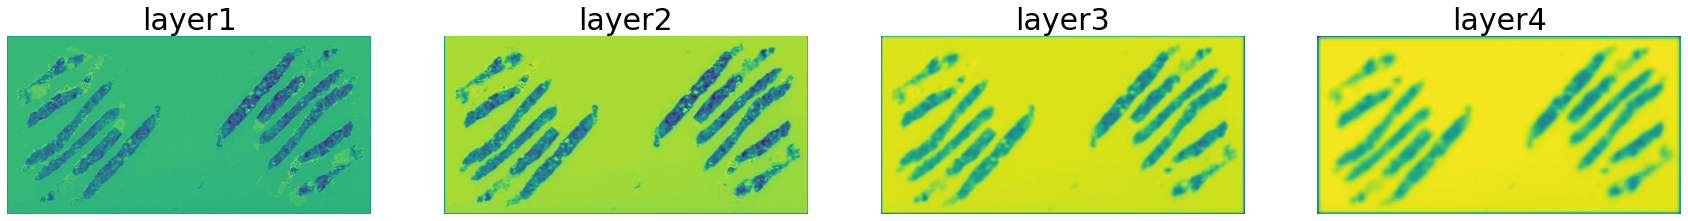

In [79]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
#plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

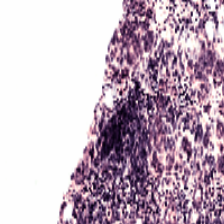

In [86]:
origin_img

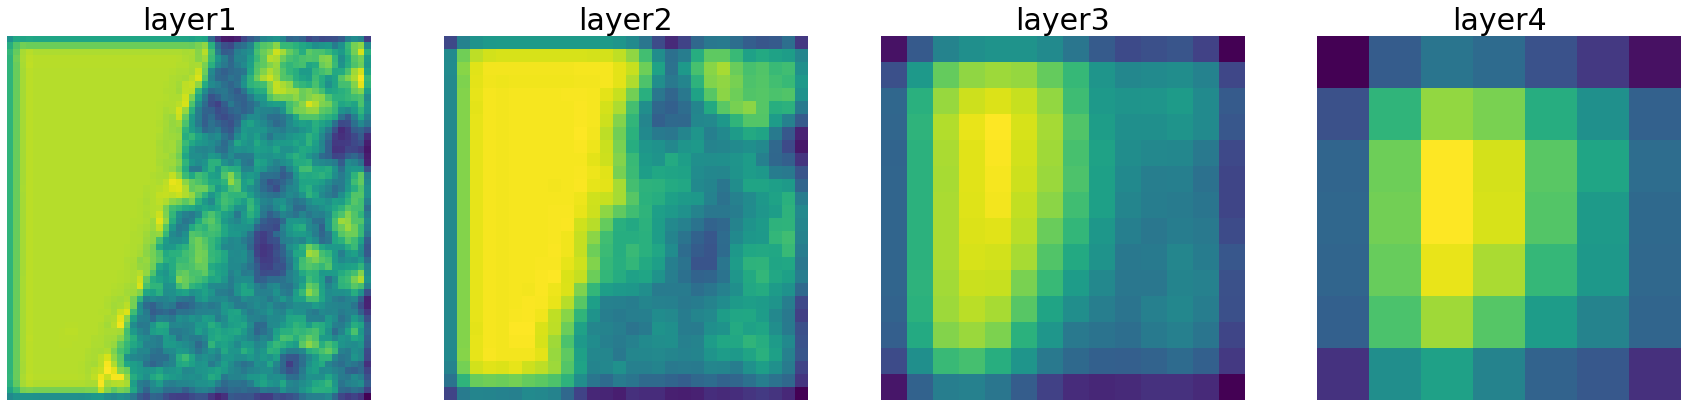

In [85]:
# 기존 resnet50
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
#plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

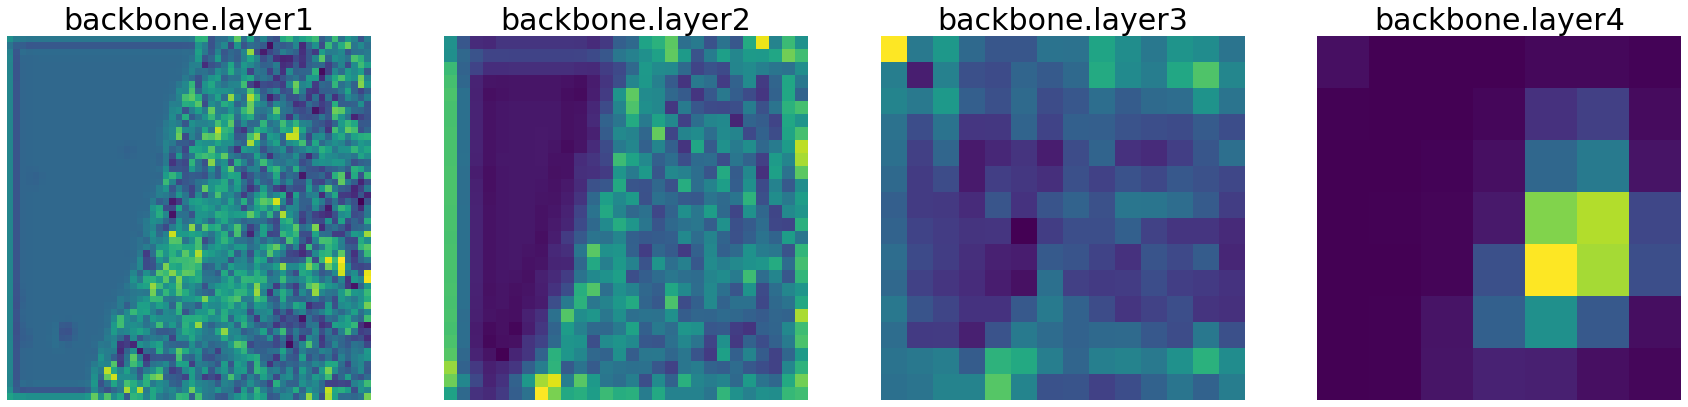

In [93]:
# train 된 resnet
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
#plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

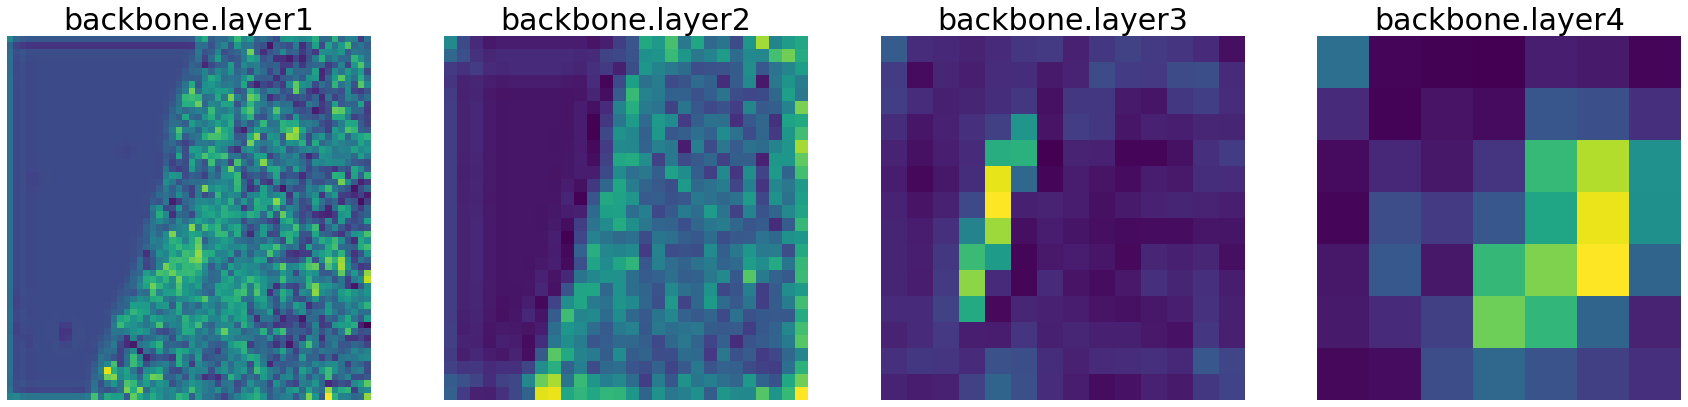

In [100]:
# train 된 resnet2
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
#plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')